IPython notebook created by Mikael Bodén. Material is derived from BIOL3014 Practical 5 (2014).

Bug fixes: m.boden@uq.edu.au

Source: https://github.com/UQ-BIOL3014/Practical5

---

# BIOL3014/BINF7000 Practical 5

## Analysing ChIP-seq data to understand transcriptional regulation
---

* **Due:** 11AM 16/09/2015
* **Revision:** 1
* **Marks:** 
    * **BIOL3014** - 8 marks. 
    * **BINF7000** - 12 marks.
---


### Objectives 

In this practical:
* You learn about issues related to processing genome-wide assays and mapping them to a genome reference sequence
* You become familiar with a few file formats that are used for storing genome-wide data
* You work with epigenetic and transcription factor binding data
* You work with transcription factor binding motifs and statistical methods to determine their enrichment in regulatory sequences
* You learn practical approaches to understand transcriptional regulation
---


### Submission requirements

Please export this IPython notebook (with written answers & completed code) to `STUDENTNUMBER_P5.ipynb` notebook and submit it via the BlackBoard portal. See the screenshot below:

![alt text](export_workbook.png "Exporting your workbook")

----


### Resources

#### Python resources:
* The UQ Bioinformatics Python Guide (on Blackboard)
* The [Python 2 documentation]. For those unfamiliar with Python the [Official tutorial] is recommended
* The software carpentry [Novice python lessons]

[Python 2 documentation]: https://docs.python.org/2/
[Official tutorial]: https://docs.python.org/2/tutorial/index.html
[Novice python lessons]: http://swcarpentry.github.io/python-novice-inflammation/

####Relevant modules:
* `sym.py` 
* `seqdata.py`
* `sequence.py` 
* `prob.py`

#### Other:
* [IPython Notebook markdown cheatsheet]

[IPython Notebook markdown cheatsheet]: https://github.com/adam-p/markdown-here/wiki/Markdown-Here-Cheatsheet#links

---

### Exercises

For all example code to work, make sure you import all required modules. If Python reports an error for the code in the cell below, chances are that you don't have the code you need, or that Python does not find it. If the latter, make sure you set the Python search path *before* you start ipython notebook, e.g.:
```
PYTHONPATH=/Users/joebloggs/uqbinfpy/uqbinfpy
export PYTHONPATH
```

In [142]:
import sym      # we are going to make reference to sequence alphabets
import sequence # for constructing sequences from genome reference data
import seqdata  # for processing genome-wide data
import prob     # for motif data

If you have the Python sources in a sub-directory `uqbinfpy` below the directory you specify in your `PYTHONPATH`, do this to import instead.

In [ ]:
from uqbinfpy import sym      # we are going to make reference to sequence alphabets
from uqbinfpy import sequence # for constructing sequences from genome reference data
from uqbinfpy import seqdata  # for processing genome-wide data
from uqbinfpy import prob     # for motif data

You will be using Numpy and matplotlib. We suggest that you make matplotlib plot its plots "in-line" so that visual results are available in the same notebook.

In [ ]:
%matplotlib inline

---
### Part 1 Analysing genome data (3 marks)
Complete all exercises in Part 1. You must provide responses to requests highlighted in <span style="color:red">**red**</span>.

Before getting to the exercises we need to gain access to and understand three biologically different types of data.

#### Biological data type 1: Genome reference data
The portal for the UCSC Genome Browser (http://genome.ucsc.edu) contains the reference sequence and working draft assemblies for a large collection of genomes. We will use the 2009 assembly for human, also referred to as hg19 (see http://hgdownload.soe.ucsc.edu/downloads.html).

The human genome is large (3Gb) so we will use a compressed format known as ‘2bit’ where each base is represented by 2 ‘bits’. If you are on campus, download the genome from the local server. Caution: the file is about 800MB. Make sure you save the file in the notebook directory (or remember to reference it by the directory where you put it).

http://bioinf.scmb.uq.edu.au/pubsvn/share/hg19.2bit

Fire up Python and use the module `seqdata.py` to have a closer look.

In [ ]:
hg19 = seqdata.TwoBitFile('hg19.2bit')  # assumes that the genome is stored in your current directory
for key in hg19:
    print key

To Python hg19 is a dictionary. The for-loop will show you the main pieces that make up the genome. No prizes for guessing what they correspond to… You can access each chromosome separately, but be careful not to print the actual sequence unless you provide a ‘genome location index’ or ‘range’, as exemplified below. You now have every single base in the human (reference) genome at your fingertips! 

Try to understand what the following three lines actually mean as you execute them. No need to write it down.

In [ ]:
hg19['chrX']

In [ ]:
len(hg19['chrX'])

In [ ]:
hg19['chrX'][1000000:1000060]

#### Biological data type 2: Gene annotation data

Later we will need to know where genes are placed in the human reference genome, in particular where their transcription start sites are located. 

The UCSC Genome has a ‘Table browser’ (select menu “Tables”, check the appropriate options—default should do it (knownGene), select BED-browser extensible data output format, click “get output”, select “1” bp upstream, and download file. (`hum_TSS.bed` is already in your data directory.) 

Repeat the download but this time choose 1000 bp upstream, and name the file differently. (`hum_prom.bed` is already in your directory.)

Familiarise yourself with the BED format. You can look at the file in a normal text editor. `seqdata.py` has functionality to process the data too. Each entry describes a genomic region. Notice that the most basic entry has three fields, namely *Chromosome*, *start site*, and *end site*. More complicated variants will annotate a region with information.

In [ ]:
tss = seqdata.BedFile('hum_TSS.bed')
print 'The BED file has this many entries:', len(tss)
print 'The very first one looks like this:', tss[0]
print 'The chromosome is:', tss[0].chrom
print 'The start site is:', tss[0].chromStart
print 'The end site is:', tss[0].chromEnd
print 'The tenth entry looks like this:', tss[9]
print 'It is located this many basepairs away from the first:', seqdata.distance(tss[0].loc(), tss[9].loc(), minimum=True)

#### Biological data type 3: Epigenetic, histone modification data
The Encyclopedia of DNA Elements (ENCODE; http://genome.ucsc.edu/ENCODE/) Consortium is an international collaboration of research groups funded by the National Human Genome Research Institute (NHGRI). The goal of ENCODE is to build a comprehensive parts list of functional elements in the human genome, including elements that act at the protein and RNA levels, and regulatory elements that control cells and circumstances in which a gene is active.

ChIP-seq has been used extensively by ENCODE to determine where transcription factors bind, and where chromatin modifications and other major protein-DNA binding events occur. 

Histone-3 Lysine-4 tri-methylation (H3K4me3) is known as an active promoter mark. Histone-3 Lysine-27 acetylation (H3K27ac) is regarded as an enhancer mark. 

From the ENCODE page, go to and view the glorious Experiment matrix. Continue to the ChIP-seq experiment matrix, and download the ‘broadPeak’ files for the histone modifications. (H3K4me3.broadPeak and H3K27ac.broadPeak are in your directory.)

Once the data files are in place, you can use `seqdata.py` to load and use them. For example, you may want to find the H3K4me3 peak that is closests to a specific transcription start site, like so 

In [ ]:
h3k4me3 = seqdata.BedFile('H3K4me3.broadPeak')
print h3k4me3.closest(tss[0])     # tuple with two values: the distance, and the BED entry
print h3k4me3.closest(tss[0])[1]  # we look at the BED entry

In [ ]:
h3k27ac = seqdata.BedFile('H3K27ac.broadPeak')

With your BED files available as lists in Python, you are requested to answer questions a-c.

<span style="color:red">a. How many genes in human embryonic stem cells (hESC) are marked with H3K27ac in the first 1000 base pairs upstream of the transcription start site? </span>

<span style="color:red">b. What is the expected distance from a H3K4me3 mark and its closest gene? (Produce a mean and a distribution of distances.) </span>

<span style="color:red">c. What is the expected distance from a H3K27ac mark? (Produce a mean and a distribution of distances.)</span>

Report on your answers in the cells below. Also provide the code to determine and plot the distance distributions. Compare those between H3K4me3 and H3K27ac and confirm that they are displaying what you would expect regarding their associations with promoters and enhancers. (Some example code below, but you may have to do some changes. Note that we log-transform the distances, and avoid log(0) by adding “1” to each distance. We also add a parameter `False` to `closest` to use centre-to-centre distances as opposed to the default “minimal” boundary-to-boundary distances.)

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

d_h3k4me3 = []
for mark in h3k4me3:
    d_h3k4me3.append(math.log10(tss.closest(mark, False)[0]+1))
d_h3k27ac = []
for mark in h3k27ac:
    d_h3k27ac.append(math.log10(tss.closest(mark, False)[0]+1))
plt.figure(1, figsize=(8,8))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])
n, bs, ps = plt.hist(d_h3k27ac, 100, normed=1, color='r', histtype = 'step')
n, bs, ps = plt.hist(d_h3k4me3, 100, normed=1, color='g', histtype = 'step')
plt.show()

---
### Part 2 Transcription factor motif enrichment (3 marks)

Complete all exercises in Part 2. You must provide responses to requests highlighted in <span style="color:red">**red**</span>.

You are now going to analyze some sequence data taken from ChIP-seq data and try to determine what motif describes the direct DNA binding by the transcription factor (TF) that was "pulled-down" in the immunoprecipitation experiment. The sequence data you are provided with is the genomic sequence around each of the "peak" regions declared by the "peak-calling" algorithm. The ultimate mission is to perform a type of "motif enrichment analysis" (Part 3).

CEBPB is a transcription factor. Construct a FASTA file, containing all the DNA sequences with CEBPB binding sites, so that someone, maybe you, can do transcription factor binding motif discovery with it. 

Download ChIP-seq data from ENCODE for it in human embryonic stem (ES) cells. (Pick the narrowPeak file, also found in your directory as `CEBPB.narrowPeak`.)

In [ ]:
cebpb = seqdata.BedFile('CEBPB.narrowPeak')
seqs = []
for b in cebpb:
    try:
        seqstr = hg19[b.chrom][b.chromStart:b.chromEnd]
        newseq = sequence.Sequence(seqstr, sym.DNA_Alphabet, str(b))
        if len(newseq) >= 200:
            seqs.append(newseq)
    except:
        print 'Failed to map', b.chrom, b.chromStart, b.chromEnd
sequence.writeFastaFile('cebpb.fa', seqs)

<span style="color:red">a. Is CEBPB more likely to be associated with promoters or enhancers?</span>

To answer this, you need to measure distances again, and substantiate your conclusions with plots of distances between CEBPB binding sites and promoter and enhancer associated histone marks. Use the cell below to write the code to answer the question.

Above we extracted from the reference genome a set of sequences, which CEBPB seems to bind to. While this sounds like a motif discovery problem, we may already know what the CEBPB motif looks like. We will therefore look at this as a motif search problem, and establish the statistical enrichment of CEBPB's motif. Specifically, we will investigate at what position the motif occurs. Step one, is to make sure all sequences are the same length around the centre of each peak. 

<span style="color:red">b. Write the code below to set the variable `seqs200` to be the 200-bp versions of those sequences extracted above. </span>
They must be centred at the centre of the original peaks which can vary widely in size.

In [ ]:
seqs200 = []
for seq in seqs:
    centre = len(seq) / 2
    seqs200.append(sequence.Sequence(seq[centre - 100:centre + 100]))

JASPAR contains a large number of transcription factor binding motifs. You can download the whole database directly from their web site at http://jaspar.genereg.net. You can find the database in the notebook directory as `JASPAR_matrices.txt`. You can use `prob.py` to read in each motif as a list of probability distributions (over the DNA alphabet), like so:

In [ ]:
d = prob.readMultiCounts('JASPAR_matrices.txt')
print 'Just loaded', len(d), 'sequence motifs as a dictionary'

CEBPB is called `MA0466.1` in JASPAR. It is believed to have a couple of co-factors, including RUNX1 (called `MA0002.1` in JASPAR) and IRF1 (called `MA0050.2`).

In [ ]:
print 'CEBPB is called MA0466.1 in JASPAR'
d['MA0466.1']

In [ ]:
# This will print all the column-specific distributions
for col in d['MA0466.1']:
    print col

In [ ]:
# It is easy to make the list of distributions into a PWM
pwm1 = sequence.PWM(d['MA0466.1'])
pwm1.display(format='JASPAR')
print
# The TF could bind to the reverse strand too
pwm2 = pwm1.getRC()
pwm2.display(format='JASPAR')

ChIP-seq identifies fragments of DNA that the target protein binds to. While those fragments can be of different sizes, on average we expect any trace of binding to be enriched in the centre. To verify that this is the case, we first check that all sequences are the same length.

In [ ]:
seq_len = len(seqs200[0])
for seq in seqs200:
    if len(seq) != seq_len:
        print 'Error: all sequences must be of the same length, and', seq.name, 'is', len(seq), 'and not', seq_len
        break

If this turns out to be true (which it should if you managed to solve the problem above), we can determine the average position-specific score over all DNA sequences. The following code will plot those average scores.

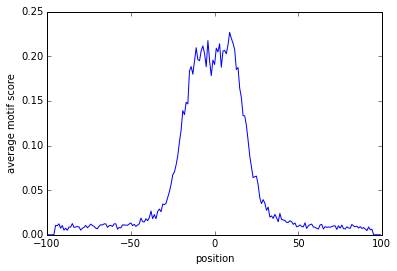

In [109]:
""" Produce a plot for the "average scan" of the specified motif. 
    The plot has as its x-axis position of sequence, and 
    the y-axis the average PWM score over all sequences. 
    Make sure the following variables are set correctly before running:
        seqs200 - all sequences to be scanned, must be same lengths
        pwm1 - PWM
        pwm2 - PWM reverse strand
    """
threshold = 0 # the minimum score for a match
seq_len = len(seqs200[0])
# initialize things to zero
avg_motif_score1 = np.zeros(seq_len)
# compute average score at each position (on both strands) in sequences
i_seq = 0
motif_width = pwm1.length
for seq in seqs200:
    i_seq += 1
    # positive strand
    hits = pwm1.search(seq, threshold)
    pos_scores = seq_len * [0]
    for hit in hits:
        # mark hit at *center* of site (hence motif_width/2)
        pos_scores[hit[0]+(motif_width/2)] = hit[2]
    # negative strand
    hits = pwm2.search(seq, threshold)
    neg_scores = seq_len * [0]
    for hit in hits:
        neg_scores[hit[0]+(motif_width/2)] = hit[2]
    # for each position use the maximum score of the two strands
    for i in range(seq_len):
        score = max(pos_scores[i], neg_scores[i])
        if (score > threshold):
            avg_motif_score1[i] += score
# compute average score
for i in range(seq_len):
    avg_motif_score1[i] /= len(seqs200)
# plot the average score curve
x = range(-(seq_len/2), (seq_len/2))    # call center of sequence X=0
plt.plot(x, avg_motif_score1)
plt.axhline(color='black', linestyle='dotted')
plt.xlabel('Position')
plt.ylabel('Average motif score')
plt.show()

<span style="color:red">c. Use the same approach to establish if there is a co-factor with CEBPB in human embryonic stem cells.</span> You can start with the two identified above but try to identify other candidates by searching the literature. (Tip: Use PubMed http://www.ncbi.nlm.nih.gov/pubmed/.) Explain what you see in both technical and biological terms. Show a plot in the notebook with all transcription factors that you discuss.

If you are doing *all* parts of this practical (BINF7000), feel free to do Part 4 before continuing with Part 3.

---
###Part 3 Transcription factor enumerative motif discovery (2 marks)

We are now going to identify what the motifs are, using an *enumerative* discovery method. Since TF binding sites are relatively short we can actually count the number of times each possible $W$-permutation of the four characters (that make up the DNA alphabet) occurs in regions of interest, where $W$ is the width of the motif. We will refer this $W$-permutations as words.

Here's a function that we will need that divides a sequence into all the words found in it.

In [ ]:
def slidewin(seq, W):
    """ Produce a list of sub-sequences of a given length from a complete sequence """
    subseqs = []
    for i in range(len(seq) - W + 1):
        subseqs.append(seq[i : i + W])
    return subseqs

Let's try it.

In [ ]:
for word in slidewin('ACGGCCACTATAGTGGCCGT', 8):
    print word

We have written a Python module `rcdict.py` with a class `RCDict` that is a simple dictionary, which maps a DNA sequence i.e. a word to a count. The only complication is that this class regards the word that appears on both strands as the same, e.g. that 'ACGGCCAC' is the same as 'GTGGCCGT'.

<span style="color:red">a. Explain why the answer to running the following code is `3`.</span>

In [ ]:
import rcdict
pos = rcdict.RCDict()
for word in slidewin('ACGGCCACTACGGTGGCCGT', 4):
    try:
        pos[word] += 1
    except KeyError:
        pos[word] = 1
print pos['CCGT']

We will now write the code that counts the words at the centre (at the peak) in a set of sequences, like those analysed above. We can define the centre width in any way we like but why not benefit from the analysis above and set it to roughly $50+50=100$.

In [106]:
WordWidth = 8
PeakWidth = 100
""" Produce a report of enriched words of specified length.
    seqs: DNA sequence data
    WordWidth: length of sought words
    PeakWidth: width of window around centre of sequence
    """
pos = rcdict.RCDict() # reverse complement-aware dictionary for DNA
for seq in seqs200:
    centre = len(seq)/2 # find peak
    """ Construct all words around peak (positives) and count their presence """
    words = set(slidewin(seq[centre-PeakWidth/2:centre+PeakWidth/2], WordWidth))
    for word in words:
        try:
            pos[word] += 1
        except KeyError:
            pos[word] = 1

allpos = pos.items() # extract all words
sortpos = sorted(allpos, key=lambda v: v[1], reverse=True) # sort them
print "Words ranked by count"
print "Word    \tCount"
for (word, lgr) in sortpos[0:10]: # Look at the top-entries according to count
    cnt_pos = int(pos[word])
    print "%s\t%d" % (word, cnt_pos)

Words ranked by count
Word    	Count
TGATGCAA	2171
TTGCACAA	1611
TTACGCAA	1541
TCACTGCA	1046
TTGCGCAA	995
ATTGTGCA	967
AGGCTGGA	900
CAGCCTGG	894
TTGCGAAA	838
ATGCAATC	793


Take note of three things in particular: (1) This is *not* an alignment. Words can be "shifted", i.e. partly overlap, with flanks that do not. (2) The printout does not contain the reverse complement, hence some similarities are seen only after a conversion. (3) There could be more than one distinct site with higher counts.

<span style="color:red">b. On the basis of the top ten counts and suggest a sequence motif in the form of a regular expression for the transcription factor, which matches a large *subset* of the ten words.</span>

---
### Part 4 Statistics of motif enrichment (2 marks; BINF7000 only)
For BINF7000, complete all exercises in Part 4. You must provide responses to requests highlighted in <span style="color:red">**bold**</span>.

The observations in both Part 2 and 3 are rather *qualitative*. We are not sure if they are statistically supported. This section will explore statistics as a means to *quantify* the strength of observations.

We are now (over several exercises) going to develop a new method that statistically quantifies the "enrichment" of a motif. 

While there is no need to write down the answers yet, think about the following questions in relation to Part 2: What do we expect the plot of a randomly chosen motif to look like? How can we decide if a plot is "centred"? How can we decide which of two motifs has a *more* "centred" (i.e. "narrower") plot?

The (one) answer is to think about a single ChIP-seq peak region.  That is, think about one of the sequences in our input set. 

i.	If you were to scan a single sequence with a "random" motif of width $W$, the probability of the best match being at position $X$, when the sequence is $L$ base-pairs long, is $\frac{1}{L - W + 1}$. The statistical distribution that describes the probability of the best match to the motif being at position $X$ is the uniform distribution.

ii.	If you scan each of the $N$ sequences with a "random" motif, and mark the location of the best match, you would expect (on average) to find 
$\frac{N}{L - W + 1}$ matches at position $X$.

The statistical distribution that describes the number of matches at position $X$ is called the binomial distribution. You will use it below. See Wikipedia to understand the basics (http://en.wikipedia.org/wiki/Binomial_distribution) before you move on.

We will now develop a new function that counts the *number of times* the best match to the motif occurs at each position $X$; we store this in an array $C[X]$.  To do this, it needs to choose one best match in each sequence.  To do that, for a given sequence, it needs to find the (set of) positions with maximal score, and choose one of them. If a sequence doesn’t have any hits (over the score threshold), nothing gets added to your array of counts.

When all of the sequences have been processed, our function divides the counts by the total, position-unspecific count (the total number of sequences that have exactly one hit), the result will be a probability distribution; $P[X]$ is $C[X]$ normalised.  That is, $P[X]$ is the probability of a single sequence having its best hit at position $X$. While it is very similar to the code in Part 2, go through the code in detail and add your own comments to each line.

Now run the new function for the CEBPB motif on the CEBPB ChIP-seq data above, using a default threshold of 0 (for counting a score as a "hit").

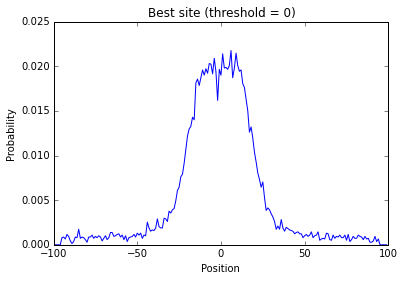

In [141]:
""" Produce a plot for a scan of the specified motif. 
    The plot has as its x-axis position of sequence, and 
    the y-axis the number of sequences with a best hit at position x. 
    Sequences with no hit above 'threshold' are ignored.
    Ties for best hit are broken randomly.
    The p-value of the central region that is most "centrally enriched"
    and the width of the best central region is printed in the label
    of the plot.
"""
import random, operator, binomial
seed = 1
random.seed(seed)
threshold = 0 # the minimum score for a match
seq_len = len(seqs200[0])
# set the random seed for repeatability
# initialize things to zero
C = np.zeros(seq_len)
n_seqs_with_hits = 0.0
# Scan each sequence for all hits on both strands and record
# the number of "best hits" at each sequence position.
motif_width = pwm1.length
i_seq = 0
for seq in seqs200:
    i_seq += 1
    # scan with both motifs
    hits = pwm1.search(seq, threshold) + pwm2.search(seq, threshold)
    # Record position of best hit
    if (hits):
        n_seqs_with_hits += 1
        # find best hit score
        best_score = max(hits, key=operator.itemgetter(1))[2]
        # find ties
        best_hits = [ hit for hit in hits if hit[2] == best_score ]
        # break ties at random
        best_hit = random.choice(best_hits)
        # mark hit at *center* of site (hence pwm1.length/2)
        C[best_hit[0] + pwm1.length/2] += 1
# divide number of sequences with hit by total number of hits
P = [ (cnt/n_seqs_with_hits) for cnt in C ]
x = range(-(seq_len/2), (seq_len/2))        # call center of sequence X=0
plt.plot(x, P)
plt.axhline(color='black', linestyle='dotted')
plt.legend(loc='best')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.title('Best site (threshold = ' + str(threshold) + ')')
plt.show()

<span style="color:red">a. Explain how this plot differs both visually and conceptually from the plot you produced in Part 2.</span> Tip: try a couple of other motifs and see how they change too.

The expectation is that a responsible binding event appears down the middle of the peak. Assuming that you have collected $C[X]$ above, the next bit of code tests if the motif is statistically supported as "centrally enriched". Intuitively the *radius* $r$ of that centre should be small, but we have to accommodate some imprecision and noise. Here's some code that calculates the significance of central enrichment for $r=1$ (the centre position plus one on each side). Try a few values of $r$ to see how the calculations change for the $C[X]$ that you calculated above.

In [140]:
centre = seq_len/2                  # centre of sequence
successes = C[centre]
r = 1
for i in range(1, r + 1):
    successes +=  + C[centre - i] + C[centre + i] # include positions at the perimeter of the radius
print 'The centre contains', successes, 'hits (successes)'
trials = n_seqs_with_hits
print 'from', trials, 'attempts (trials)'
print 'Which means that the probability of success is', successes / trials
w = 2 * r + 1 # size of window
n_scored = (seq_len - pwm1.length/2 + 1.0) # number of positions that have been scored
p_success = w / n_scored
print 'The expected probability of success is', p_success
log_pvalue = binomial.log_binomial_ncdf(trials, successes, p_success);
print 'According to the Binomial test that difference (or greater) has a cumulative probability', math.exp(log_pvalue), 'of occurring'

The centre contains 828.0 hits (successes)
from 13789.0 attempts (trials)
Which means that the probability of success is 0.0600478642396
The expected probability of success is 0.015306122449
According to the Binomial test that difference (or greater) has a cumulative probability 3.17983053652e-232 of occurring


<span style="color:red">b. Write the code below to find the best value for $r$ scanning over all possible values (from 0 to half the length of the sequence), i.e. the value that results in the smallest motif enrichment $p$-value.</span>

---
### Part 5 Statistics of enumerative motif discovery (2 marks; BINF7000 only)
For BINF7000, complete all exercises in Part 5. You must provide responses to requests highlighted in <span style="color:red">**bold**</span>.

Our motif discovery method above has a couple of issues.

First, biological sequences are *not* uniform. Indeed some motifs may occur more often for no interesting reason. So, for motif discovery it is important to use a background--but you already knew that.

Second, the motif should *preferentially* occur in the centre of the sequence. Above, we counted everything up until a boundary was reached.

We will now write code that kills both birds with one stone. Everything *inside* a radius of the centre is "foreground"; everything *outside* is "background".

In [149]:
import stats

WordWidth = 8
PeakWidth = 100
PeakMargin = 10
""" Produce a report of enriched words of specified length.
    seqs: DNA sequence data
    WordWidth: length of sought words
    PeakWidth: width of window around centre of sequence
    PeakMargin: the width of the margin on each side of the centre window
    (which delineates the positives around peak from negatives away from peak). 
    """
pos = rcdict.RCDict() # reverse complement-aware dictionary for DNA
neg = rcdict.RCDict() # reverse complement-aware dictionary for DNA
for seq in seqs200:
    centre = len(seq)/2 # find peak
    """ Construct all words around peak (positives) and count their presence """
    words = set(slidewin(seq[centre-PeakWidth/2:centre+PeakWidth/2], WordWidth))
    for word in words:
        try:
            pos[word] += 1
        except KeyError:
            pos[word] = 1
    """ Construct all words away from peak (negatives) and count """
    words = set(slidewin(seq[:centre-PeakWidth/2-PeakMargin], WordWidth))
    words.union(slidewin(seq[centre+PeakWidth/2+PeakMargin:], WordWidth))
    for word in words:
        try:
            neg[word] += 1
        except KeyError:
            neg[word] = 1

In essence, we are simply counting words in the background and keeping those counts in a separate `RCDict` instance.
Next, for each word we calculate the log ratio between its count in the foreground and its count in the background. Big values are of course an indication of domination of the *inside* counts.

In [150]:
logratio = rcdict.RCDict() # DNA dictionary for storing the log-ratio between pos and neg
for (word, cnt_pos) in pos.items():
    cnt_neg = 0.0001
    try:
        cnt_neg = neg[word]
    except KeyError:
        pass
    logratio[word] = math.log(float(cnt_pos) / float(cnt_neg))
allpos = logratio.items() # extract all pairs of words:log-ratio
sortpos = sorted(allpos, key=lambda v: v[1], reverse=True) # sort them

Finally, we make the statistical evaluation. We ask: are these counts so different that in less than 5% of trials chance can explain the outcome?

In [153]:
print "Enriched words (sorted by ln pos/neg)"
print "Word    \tln pos/neg\tE-value"
for (word, lgr) in sortpos[0:10]: # Look at the top-entries according to log-ratio, compute p-values
    cnt_pos = int(pos[word])
    try: cnt_neg = int(neg[word])
    except KeyError: cnt_neg = 0 
    # Compute p-value using Fisher's Exact test
    pval = stats.getFETpval(cnt_pos, cnt_neg, len(seqs) * (PeakWidth - WordWidth + 1) - cnt_pos, len(seqs) * (len(seq) - (PeakMargin * 2 + PeakWidth) - (WordWidth - 1) * 2) - cnt_neg, False)
    if pval <= 0.05:
        print "%s\t%6.3f  \t%e" % (word, lgr, pval)

Enriched words (sorted by ln pos/neg)
Word    	ln pos/neg	E-value
TTGCGCAA	16.113  	1.533009e-232
TACGCAAT	15.251  	1.460528e-98
ATTGCGTA	15.246  	4.270196e-98
GTTGCGCA	14.947  	6.170583e-73
CTTACGCA	14.894  	3.292953e-69
AGTTGCGC	14.866  	2.405485e-67
GTTGCGTA	14.767  	4.686496e-61
TTCGCAAT	14.716  	5.002211e-58
GCGTAACA	14.576  	1.423569e-50
GTCGCAAT	14.078  	5.248774e-31


<span style="color:red">
Add code to the method above to correct for multiple testing. Then respond to the following problems in the cell below.</span>

i. In the table you should now print the E-value of each enriched word.

ii. Generate plots for at least three transcription factors, including CEBPB, and include them here, with labels that indicate their central enrichment E-values.

iii. In relation to your results for CEBPB in Part 3, are the words the same or different? Try to rationalise any similarities or differences.